In [2]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt

In [3]:
IMAGE_SIZE=256
BATCH_SIZE=32
CHANNELS=3
EPOCHS=50
n_classes=3

In [4]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)


Found 2152 files belonging to 3 classes.


In [42]:
print(dataset)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


In [5]:
class_names=dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [6]:
len(dataset)


68

(32, 256, 256, 3)
tf.Tensor([1 1 0 1 0 1 0 1 0 0 1 1 1 1 1 0 0 1 0 0 1 1 1 1 1 1 1 1 0 2 1 0], shape=(32,), dtype=int32)
(256, 256, 3)


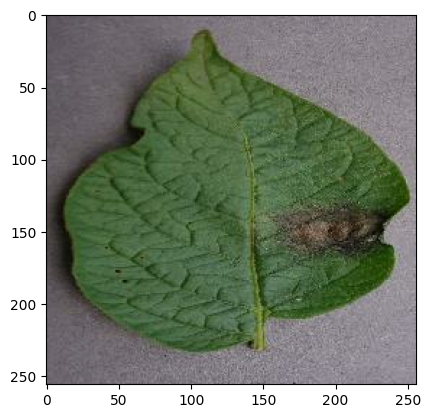

In [7]:
for image_batch,label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch)
    # each image dimention
    print(image_batch[0].shape)
    plt.imshow(image_batch[0].numpy().astype('uint'))

In [8]:
int(0.8*len(dataset))

54

In [9]:
int(0.1*len(dataset))

6

In [10]:
# 80% ==> training data
# 20% ==> 10% validation,10%testing
# train_size=0.8
# train_ds=dataset.take(int(train_size*len(dataset)))
# test_ds= dataset.skip(int(train_size*len(dataset)))
# val_ds=test_ds.take(int(0.5*len(test_ds)))
# test_ds=test_ds.skip(int(0.5*len(test_ds)))

In [11]:
def get_dataset_partitions_tf(ds,train_split=0.8,val_split=0.1,test_split=0.1,shuffle=True,shuffle_size=10000):
    ds_size=len(ds)
    if shuffle:
        ds=ds.shuffle(shuffle_size,seed=12)
    val_size=int(val_split*ds_size)
    train_ds=ds.take(int(train_split*ds_size))
    val_ds=ds.skip(int(train_split*ds_size)).take(val_size)
    test_ds=ds.skip(int(train_split*ds_size)).skip(val_size)

    return train_ds,val_ds,test_ds
    

In [12]:
train_ds,val_ds,test_ds=get_dataset_partitions_tf(dataset)

In [13]:
len(train_ds),len(val_ds),len(test_ds)

(54, 6, 8)

In [14]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [15]:
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1./255),
])

In [16]:
data_augmentation=tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2)
])

In [17]:
model=models.Sequential([
    resize_and_rescale,
    data_augmentation,
    #             filters  kernalSizeOfFiters
    layers.Conv2D(  32    ,      (3,3)   ,  activation='relu',input_shape=(BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,3)),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64,activation='relu'),
    layers.Dense(n_classes,activation='softmax')
])

model.build(input_shape=(BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,3))

C:\Users\Dell\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [18]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (32, 254, 254, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (32, 127, 127, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (32, 125, 125, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (32, 62, 62, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (32, 60, 60, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (32, 30, 30, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (32, 28, 28, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (32, 14, 14, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (32, 12, 12, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (32, 6, 6, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (32, 4, 4, 64)         │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (32, 2, 2, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (32, 256)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (32, 64)               │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (32, 3)                │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 183,747 (717.76 KB)

 Trainable params: 183,747 (717.76 KB)

 Non-trainable params: 0 (0.00 B)

In [19]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [20]:
model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 157s 3s/step - accuracy: 0.4609 - loss: 0.9561 - val_accuracy: 0.6146 - val_loss: 0.9043
Epoch 2/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 125s 2s/step - accuracy: 0.6080 - loss: 0.8054 - val_accuracy: 0.7396 - val_loss: 0.5298
Epoch 3/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 123s 2s/step - accuracy: 0.7833 - loss: 0.4852 - val_accuracy: 0.8333 - val_loss: 0.3337
Epoch 4/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 117s 2s/step - accuracy: 0.8559 - loss: 0.3734 - val_accuracy: 0.8906 - val_loss: 0.2549
Epoch 5/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 126s 2s/step - accuracy: 0.8997 - loss: 0.2758 - val_accuracy: 0.9167 - val_loss: 0.1755
Epoch 6/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 126s 2s/step - accuracy: 0.9093 - loss: 0.2369 - val_accuracy: 0.9219 - val_loss: 0.1868
Epoch 7/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 122s 2s/step - accuracy: 0.9260 - loss: 0.1832 - val_accuracy: 0.8958 - val_loss: 0.2172
Epoch 8/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 125s 2s/step - accuracy: 0.9383 - loss: 0.1593 - val_accuracy: 0.9323 - v

In [21]:
model.evaluate(test_ds)

8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 311ms/step - accuracy: 0.9226 - loss: 0.4215


[0.33051326870918274, 0.921875]

In [22]:
import numpy as np
print(np.array([[1,2,3],[1,2,1],[3,4,2]]).shape)
tf.expand_dims(np.array([[1,2,3],[1,2,1],[3,4,2]]),0)

(3, 3)


<tf.Tensor: shape=(1, 3, 3), dtype=int32, numpy=
array([[[1, 2, 3],
        [1, 2, 1],
        [3, 4, 2]]])>

In [23]:

def predict(model,img):
    # print("dvvvvvvvv",img)
    img_array=tf.keras.preprocessing.image.img_to_array(img.numpy())
    # print("before",img_array.shape)
    img_array=tf.expand_dims(img_array,0)
    # print("after",img_array.shape)
    predictions=model.predict(img_array)
    # print(predictions)
    predicted_class=class_names[np.argmax(predictions[0])]
    confidence=round(100*(np.max(predictions[0])),2)
    return predicted_class,confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 521ms/step


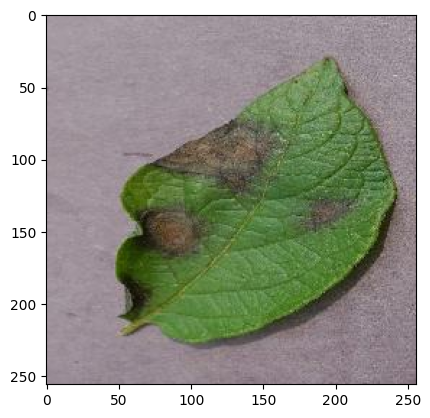

In [24]:
for images,labels in test_ds.take(1):
    # print(images[0].shape)
    prediction=predict(model,images[0])
    # print("Actual Value is",class_names[labels[0]])
    plt.imshow(images[0].numpy().astype('uint'))
    # print("predicted Value is",prediction[0])
    
    

In [43]:
model_version=3
model.save(f"../saved_models/{model_version}.h5")

TypeError: cannot pickle 'module' object

In [26]:
# saved_model=tf.keras.models.load_model("../saved_models/4.keras")

In [27]:
# type(tf.keras.preprocessing.image.img_to_array(images[0].numpy()))

In [28]:
# saved_model.predict(tf.expand_dims(tf.keras.preprocessing.image.img_to_array(images[0].numpy()),0));

In [40]:
image=np.array(list(images[0]))
type(image)
image=tf.expand_dims(image,0)
type(image)
image.shape

TensorShape([1, 256, 256, 3])

In [41]:
model.predict(image)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step


array([[3.6155848e-06, 9.9999642e-01, 2.6849464e-13]], dtype=float32)